In [1]:
import os
import torch
import numpy as np
import pandas as pd
import seaborn as sns
from torch import nn, optim
from datetime import datetime
import matplotlib.pyplot as plt
from sklearn import preprocessing
import torch.nn.functional as func
from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix, classification_report
%matplotlib inline

In [5]:
df = pd.read_csv("weather_corato.csv", index_col="datetime", parse_dates=True)
features_and_target = ["temperature", "relativehumidity", "pressure_msl", "precipitation"]
df = df[features_and_target]

In [6]:
df.describe()

,temperature,relativehumidity,pressure_msl,precipitation
count,65018.000000,65018.000000,65018.000000,65018.000000
mean,16.041801,71.218601,1015.651829,0.073796
std,7.513854,17.651779,6.722342,0.324917
min,-8.100000,10.000000,985.100000,0.000000
25%,10.000000,58.000000,1011.700000,0.000000
50%,15.300000,73.000000,1015.300000,0.000000
75%,21.600000,86.000000,1019.600000,0.000000
max,40.200000,100.000000,1040.400000,13.600000


In [7]:
# fill missing dates (if there are any)
new_date_range = pd.date_range(start="2016-01-01 00:00:00", end="2022-12-31 23:00:00", freq="H")
df = df.reindex(new_date_range, fill_value=np.nan)
df

,temperature,relativehumidity,pressure_msl,precipitation
2016-01-01 00:00:00,3.4,87,1027.2,0.0
2016-01-01 01:00:00,3.1,91,1026.9,0.0
2016-01-01 02:00:00,2.5,94,1026.7,0.0
2016-01-01 03:00:00,1.9,95,1026.8,0.0
2016-01-01 04:00:00,1.7,96,1026.8,0.0
...,...,...,...,...
2022-12-31 19:00:00,12.4,89,1030.8,0.0
2022-12-31 20:00:00,10.6,94,1031.1,0.0
2022-12-31 21:00:00,10.2,91,1031.4,0.0
2022-12-31 22:00:00,8.4,96,1031.5,0.0


In [8]:
df.isnull().sum()

temperature         0
relativehumidity    0
pressure_msl        0
precipitation       0
dtype: int64

In [9]:
df.dtypes

temperature         float64
relativehumidity      int64
pressure_msl        float64
precipitation       float64
dtype: object

In [10]:
df["precipitation"] = df["precipitation"].apply(lambda x: 1 if x > 0 else 0)
df["precipitation"].value_counts()

0    54049
1     7319
Name: precipitation, dtype: int64

In [11]:
df

,temperature,relativehumidity,pressure_msl,precipitation
2016-01-01 00:00:00,3.4,87,1027.2,0
2016-01-01 01:00:00,3.1,91,1026.9,0
2016-01-01 02:00:00,2.5,94,1026.7,0
2016-01-01 03:00:00,1.9,95,1026.8,0
2016-01-01 04:00:00,1.7,96,1026.8,0
...,...,...,...,...
2022-12-31 19:00:00,12.4,89,1030.8,0
2022-12-31 20:00:00,10.6,94,1031.1,0
2022-12-31 21:00:00,10.2,91,1031.4,0
2022-12-31 22:00:00,8.4,96,1031.5,0


In [12]:
features = features_and_target[:-1]
for feat in features:
  df[f"{feat}_diff"] = df[feat].diff(periods=1)

# remove first two records
df = df[1:]

In [13]:
df

,temperature,relativehumidity,pressure_msl,precipitation,temperature_diff,relativehumidity_diff,pressure_msl_diff
2016-01-01 01:00:00,3.1,91,1026.9,0,-0.3,4.0,-0.3
2016-01-01 02:00:00,2.5,94,1026.7,0,-0.6,3.0,-0.2
2016-01-01 03:00:00,1.9,95,1026.8,0,-0.6,1.0,0.1
2016-01-01 04:00:00,1.7,96,1026.8,0,-0.2,1.0,0.0
2016-01-01 05:00:00,1.5,96,1026.7,0,-0.2,0.0,-0.1
...,...,...,...,...,...,...,...
2022-12-31 19:00:00,12.4,89,1030.8,0,-0.3,-1.0,0.2
2022-12-31 20:00:00,10.6,94,1031.1,0,-1.8,5.0,0.3
2022-12-31 21:00:00,10.2,91,1031.4,0,-0.4,-3.0,0.3
2022-12-31 22:00:00,8.4,96,1031.5,0,-1.8,5.0,0.1


In [14]:
df["precipitation_next_hour"] = df["precipitation"].shift(-1)
df = df[:-1]
df["precipitation_next_hour"] = df["precipitation_next_hour"].astype(int)
df.drop(columns=["precipitation"], inplace=True)

<ipython-input-14-bbe19e4c6c49>:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df["precipitation_next_hour"] = df["precipitation"].shift(-1)
<ipython-input-14-bbe19e4c6c49>:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df["precipitation_next_hour"] = df["precipitation_next_hour"].astype(int)
<ipython-input-14-bbe19e4c6c49>:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user

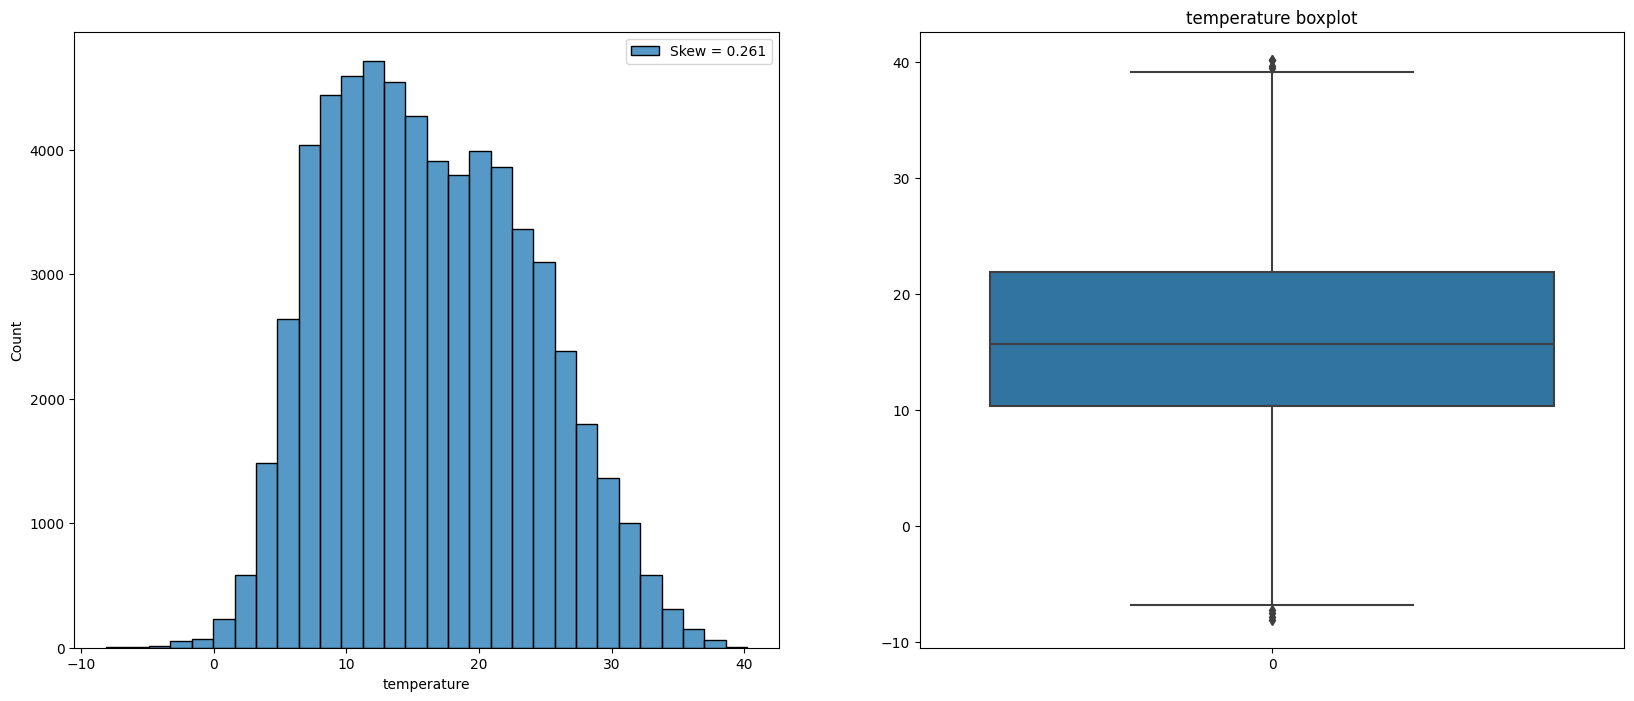

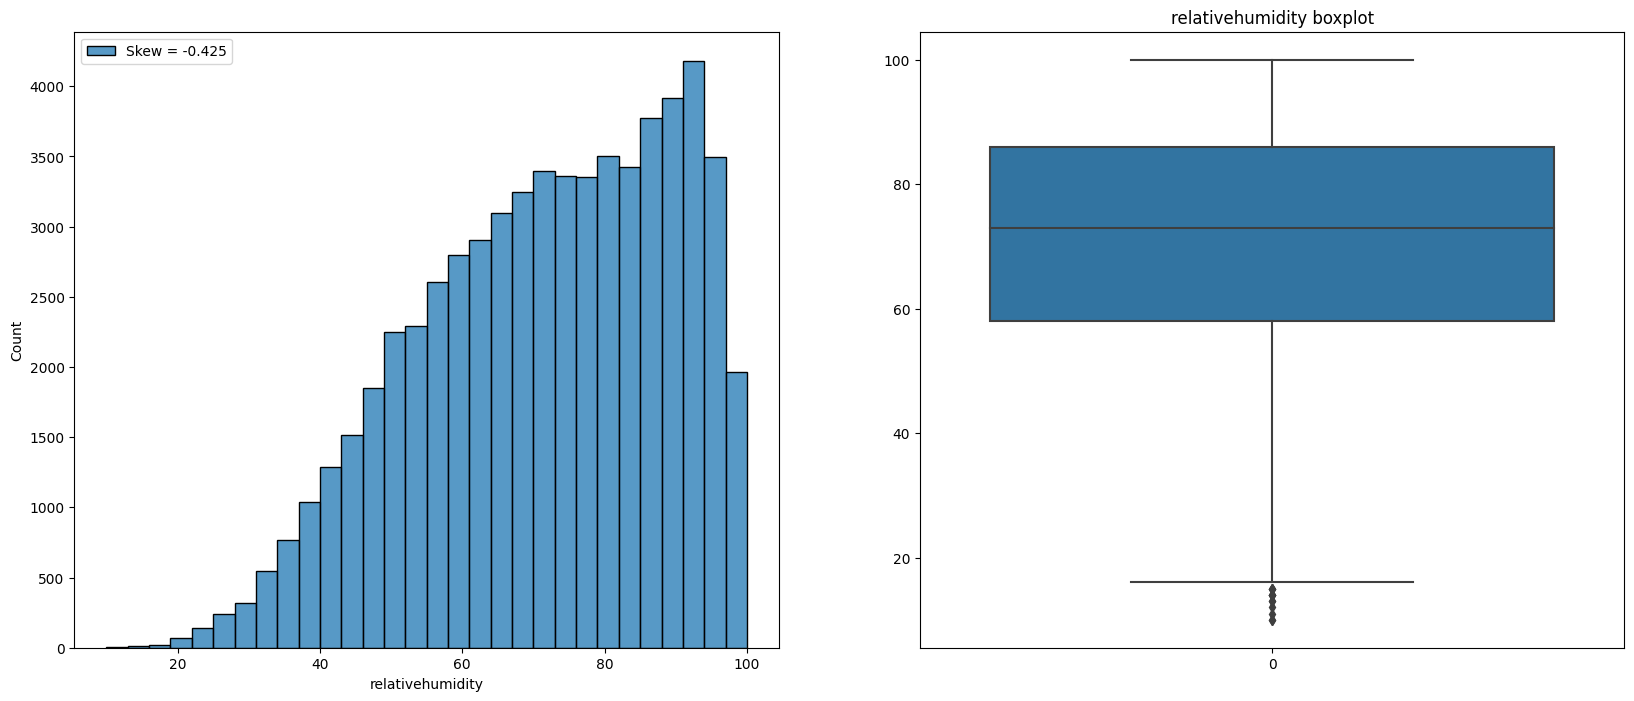

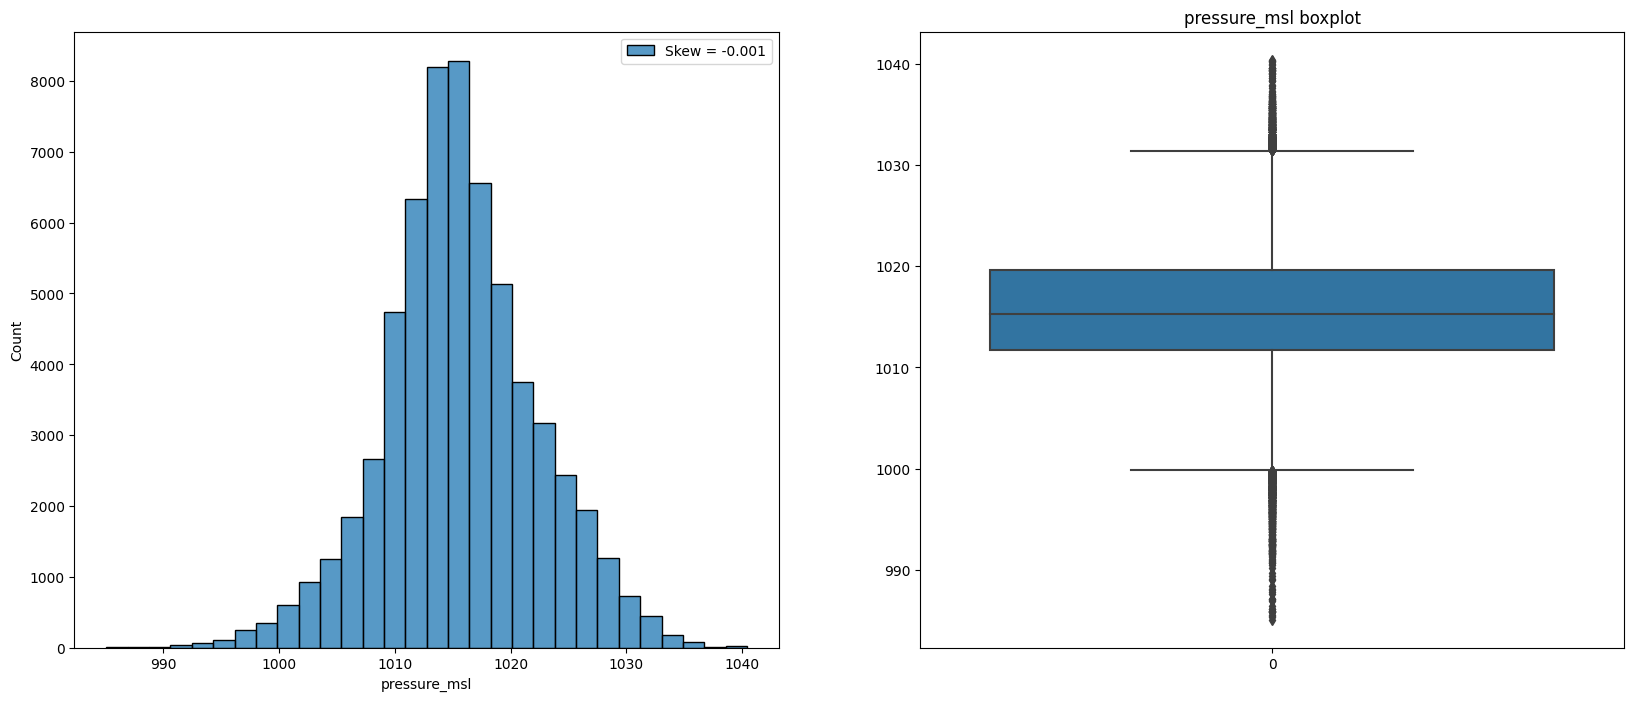

In [15]:
# ricerca outliers
for feat in features:
  fig, (ax1, ax2) = plt.subplots(1,2, figsize=(20,8))
  skew = df[feat].skew()
  sns.histplot(df[feat], kde=False, label=f"Skew = {skew:.3f}", bins=30, ax=ax1)
  ax1.legend(loc="best")
  sns.boxplot(df[feat], ax=ax2)
  ax2.set_title(f"{feat} boxplot")

In [16]:
from collections import Counter

def outlier_hunt(df, features, feat_out):
  outliers_indices = []
  for feat in features:
    Q1 = np.percentile(df[feat], 25)
    Q3 = np.percentile(df[feat], 75)

    IQR = Q3 - Q1
    outlier_step = 1.5*IQR

    outlier_list_col = df[(df[feat] < Q1 - outlier_step) | (df[feat] > Q3 + outlier_step)].index
    print(f"{len(outlier_list_col)} outliers found for feature: {feat}")
    outliers_indices.extend(outlier_list_col)
  
  outliers_indices = Counter(outliers_indices)
  multiple_outliers = list(k for k, v in outliers_indices.items() if v >= feat_out)
  return multiple_outliers

In [17]:
outliers = outlier_hunt(df, features, 2)

8 outliers found for feature: temperature
13 outliers found for feature: relativehumidity
1478 outliers found for feature: pressure_msl


In [18]:
print(f"{len(outliers)} outliers will be removed")
df = df.drop(outliers)

3 outliers will be removed


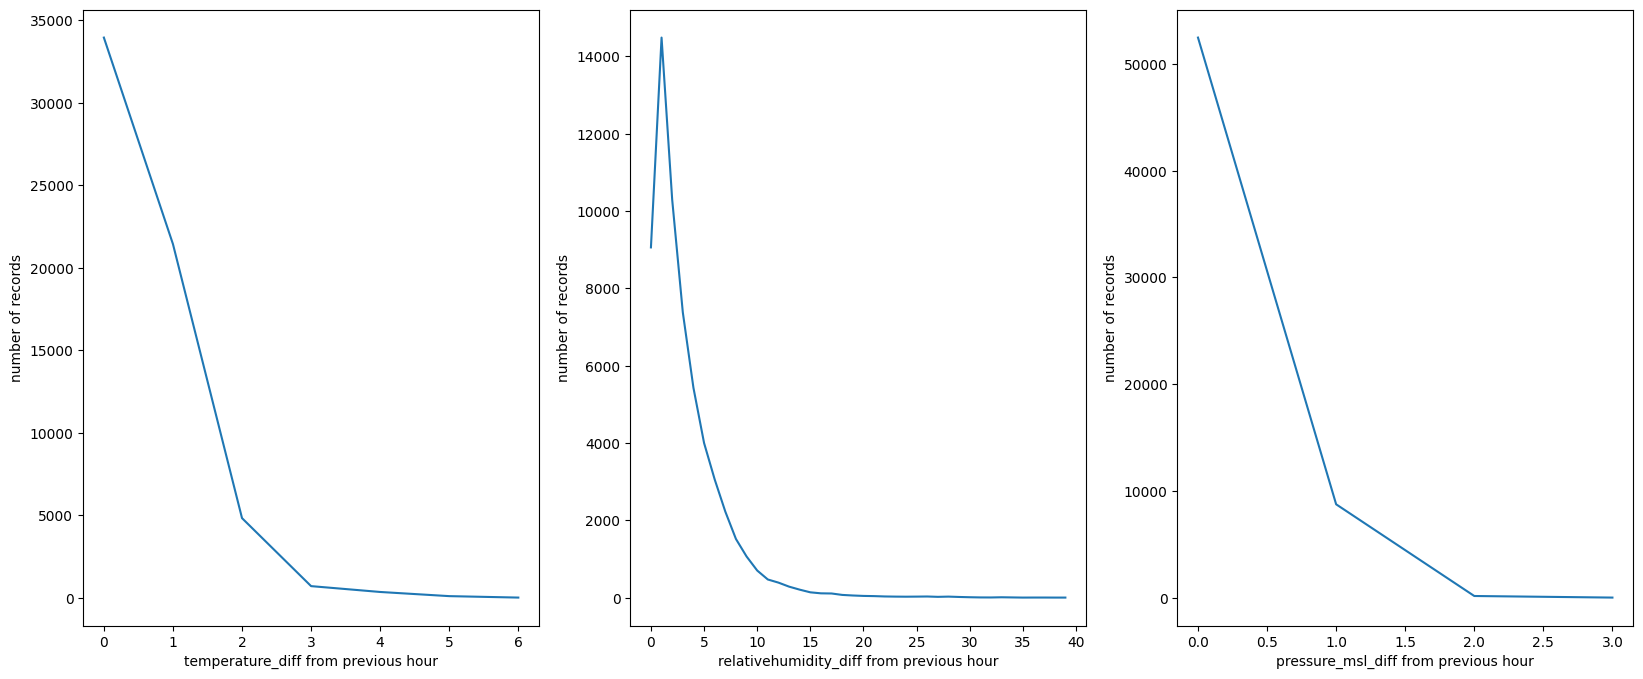

In [19]:
# plot differences
differences_col = ['temperature_diff', 'relativehumidity_diff', 'pressure_msl_diff']
fig, (ax1, ax2, ax3) = plt.subplots(1,3, figsize=(20,8))
axs = [ax1, ax2, ax3]
for num, col in enumerate(differences_col):
  diff = df[col].tolist()
  min_dc = np.min(np.abs(diff))
  max_dc = np.max(np.abs(diff))
  sta_dc = np.zeros(round(max_dc) + 1)
  for i in range(0, len(diff)):
   sta_dc[round(np.abs(diff[i]))] = sta_dc[round(np.abs(diff[i]))] + 1

  axs[num].plot(sta_dc)
  axs[num].set_xlabel(f"{col} from previous hour")
  axs[num].set_ylabel("number of records")

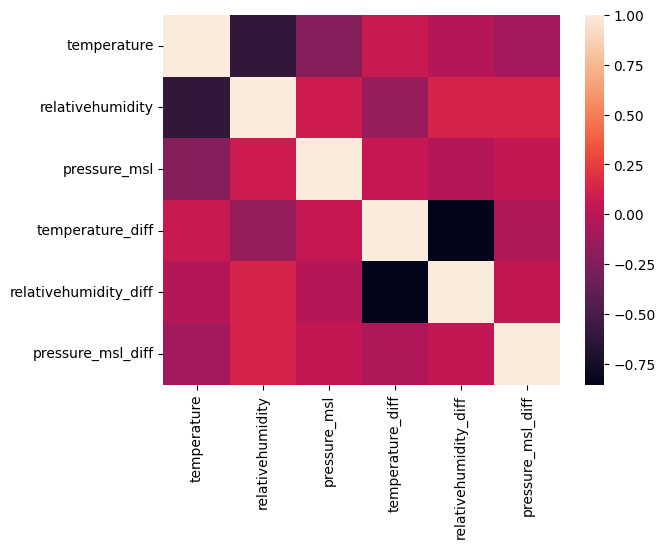

In [20]:
import seaborn as sns
%matplotlib inline

features = df.columns[:-1]

sns.heatmap(df[features].corr())
plt.savefig('correlation.png', dpi=300)

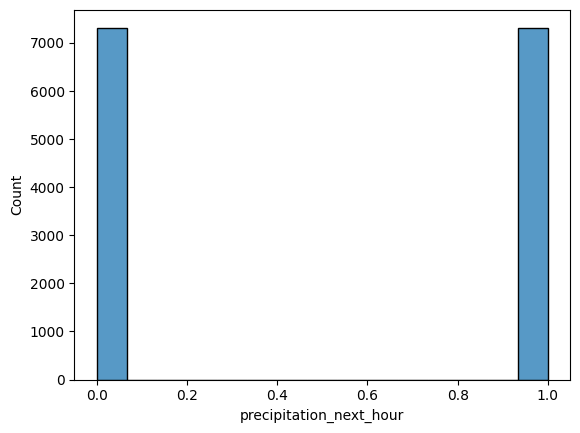

In [21]:
g = df.groupby('precipitation_next_hour')
df = pd.DataFrame(g.apply(lambda x: x.sample(g.size().min()).reset_index(drop=True)))
sns.histplot(df["precipitation_next_hour"])
plt.savefig("count_target.png", dpi=300)

In [22]:
df["precipitation_next_hour"].value_counts()

0    7319
1    7319
Name: precipitation_next_hour, dtype: int64

In [23]:
X = df[features].values
y = df[["precipitation_next_hour"]].values

In [24]:
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(X, y, stratify=y, test_size=0.2,  shuffle=True, random_state=42)

In [25]:
# Apply normalization
from sklearn.preprocessing import StandardScaler
scaler = StandardScaler()

X_train = scaler.fit_transform(X_train)
X_test = scaler.transform(X_test)

In [26]:
# save scaler to file
import joblib
joblib.dump(scaler, "./scaler.save")

['./scaler.save']

In [27]:
# Create validation set
X_train, X_valid, y_train, y_valid = train_test_split(X_train, y_train, stratify=y_train, test_size=0.2, shuffle=True)

# Neural Net

In [28]:
import torch
X_train = torch.from_numpy(X_train).float()
y_train = torch.squeeze(torch.from_numpy(y_train).float())

X_valid = torch.from_numpy(X_valid).float()
y_valid = torch.squeeze(torch.from_numpy(y_valid).float())

X_test = torch.from_numpy(X_test).float()
y_test = torch.squeeze(torch.from_numpy(y_test).float())

In [29]:
print(X_train.shape, y_train.shape)
print(X_valid.shape, y_valid.shape)
print(X_test.shape, y_test.shape)

torch.Size([9368, 6]) torch.Size([9368])
torch.Size([2342, 6]) torch.Size([2342])
torch.Size([2928, 6]) torch.Size([2928])


In [30]:
import torch.nn as nn
import torch.nn.functional as func

# Create the model
class Model(nn.Module):
  def __init__(self, n_features):
    super(Model, self).__init__()
    self.fc1 = nn.Linear(n_features, 64)
    self.fc2 = nn.Linear(64, 128)
    self.fc3 = nn.Linear(128, 1)

    #self.dropout = nn.Dropout(0.2)

  def forward(self, x):
    x = func.relu(self.fc1(x))
    x = func.relu(self.fc2(x))
    return torch.sigmoid(self.fc3(x))

In [31]:
model = Model(X_train.shape[1])

In [32]:
import torch.optim as optim

# Criterion
criterion = nn.BCELoss()
# Optimizer
optimizer = optim.Adam(model.parameters(), lr=0.001)

In [33]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

In [34]:
model = model.to(device)
criterion = criterion.to(device)

In [35]:
from torch.utils.data import DataLoader, TensorDataset
train_dataset = TensorDataset(X_train, y_train)
train_loader = DataLoader(train_dataset, batch_size=150)

valid_dataset = TensorDataset(X_valid, y_valid)
valid_loader = DataLoader(valid_dataset, batch_size=150)

Epoch 1	Training loss: 0.612807	Valid loss: 0.584510
Validation loss decreased: inf -> 0.584510. Saving model...

Epoch 2	Training loss: 0.574826	Valid loss: 0.575481
Validation loss decreased: 0.584510 -> 0.575481. Saving model...

Epoch 3	Training loss: 0.567481	Valid loss: 0.569036
Validation loss decreased: 0.575481 -> 0.569036. Saving model...

Epoch 4	Training loss: 0.561476	Valid loss: 0.563969
Validation loss decreased: 0.569036 -> 0.563969. Saving model...

Epoch 5	Training loss: 0.556446	Valid loss: 0.559810
Validation loss decreased: 0.563969 -> 0.559810. Saving model...

Epoch 6	Training loss: 0.552394	Valid loss: 0.556476
Validation loss decreased: 0.559810 -> 0.556476. Saving model...

Epoch 7	Training loss: 0.548999	Valid loss: 0.553776
Validation loss decreased: 0.556476 -> 0.553776. Saving model...

Epoch 8	Training loss: 0.546097	Valid loss: 0.551542
Validation loss decreased: 0.553776 -> 0.551542. Saving model...

Epoch 9	Training loss: 0.543507	Valid loss: 0.549400


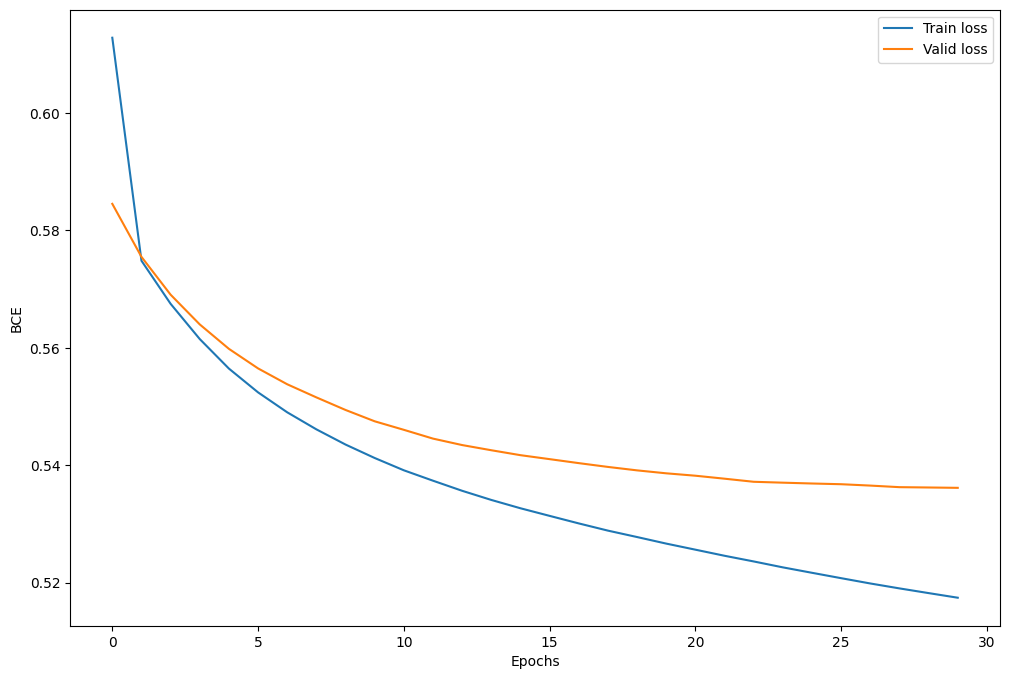

In [36]:
n_epochs = 30
valid_loss_min = np.Inf
best_model_dict = None

train_losses = []
valid_losses = []

for epoch in range(n_epochs):

  train_loss = 0.0
  valid_loss = 0.0

  ###################
  # train the model #
  ###################
  model.train()
  for data, target in train_loader:
    data, target = data.to(device), target.to(device)
    # 1. clear the gradients
    optimizer.zero_grad()
    # 2. forward pass
    y_pred = model(data)
    # 3. calculate the loss
    y_pred = torch.squeeze(y_pred)
    loss = criterion(y_pred, target)
    # 4. backward pass
    loss.backward()
    # 5. single optimization step
    optimizer.step()
    
    train_loss += loss.item()*data.size(0)

  ######################    
  # validate the model #
  ######################
  model.eval()
  for data, target in valid_loader:
    data, target = data.to(device), target.to(device)
    y_pred = model(data)
    y_pred = torch.squeeze(y_pred)
    loss = criterion(y_pred, target)

    valid_loss += loss.item()*data.size(0)

  train_loss = train_loss/len(train_loader.sampler)
  train_losses.append(train_loss)
  valid_loss = valid_loss/len(valid_loader.sampler)
  valid_losses.append(valid_loss)
  print(f"Epoch {epoch+1}\tTraining loss: {train_loss:.6f}\tValid loss: {valid_loss:.6f}")

  if valid_loss <= valid_loss_min:
    print(f"Validation loss decreased: {valid_loss_min:.6f} -> {valid_loss:.6f}. Saving model...\n")
    best_model_dict = model.state_dict()
    valid_loss_min = valid_loss

plt.figure(figsize=(12,8))
plt.plot(train_losses, label="Train loss")
plt.plot(valid_losses, label="Valid loss")
plt.xlabel("Epochs")
plt.ylabel("BCE")
plt.legend()
plt.savefig("loss_curves.png", dpi=300)

In [37]:
# save best model
torch.save(best_model_dict, "./model")

In [38]:
# load model with lowest valid loss
model.load_state_dict(torch.load("./model"))

<All keys matched successfully>

In [39]:
model.eval()
model.to('cpu')
y_pred = model(X_test)
y_pred = y_pred.ge(.5).view(-1).cpu()
y_test = y_test.cpu()

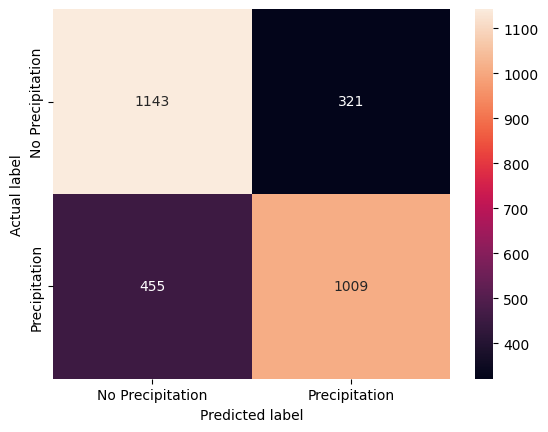

In [40]:
classes = ["No Precipitation", "Precipitation"]
conf_mat = confusion_matrix(y_test, y_pred)
df_conf_mat = pd.DataFrame(conf_mat, index = classes, columns = classes)
heat_map = sns.heatmap(df_conf_mat, annot = True, fmt = "d")
plt.ylabel("Actual label")
plt.xlabel("Predicted label")
plt.savefig("confusion_matrix.png", dpi=300)

In [41]:
print(classification_report(y_test, y_pred, target_names=classes))

                  precision    recall  f1-score   support

No Precipitation       0.72      0.78      0.75      1464
   Precipitation       0.76      0.69      0.72      1464

        accuracy                           0.73      2928
       macro avg       0.74      0.73      0.73      2928
    weighted avg       0.74      0.73      0.73      2928

